In [1]:
%%configure -f
{
    "name": "click_choice3",
    "driverMemory":"1000M",
    "executorMemory": "8000M", 
    "executorCores": 4,
    "numExecutors" :25,
    "conf": 
    {
        "spark.yarn.appMasterEnv.PYSPARK_PYTHON":"pyspark_env_1.3/bin/python",
        "spark.pyspark.driver.python":"pyspark_env_1.3/bin/python",
        "spark.pyspark.python":"pyspark_env_1.3/bin/python",
        "spark.yarn.dist.archives":"hdfs://mycluster/user/webuser/ai/pyspark/env/pyspark_env_1.3.zip#pyspark_env_1.3",
        "spark.jars": "hdfs://mycluster/user/webuser/531/pyspark/env/hudi-spark-bundle_2.11-0.7.0.jar",
        "spark.driver.extraClassPath": "hdfs://mycluster/user/webuser/531/pyspark/env/hudi-spark-bundle_2.11-0.7.0.jar",
        "spark.executor.extraClassPath": "hudi-spark-bundle_2.11-0.7.0.jar",
        "spark.sql.broadcastTimeout": "3600"
        
    }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
623,application_1600149154303_686751,pyspark,idle,Link,Link,
625,application_1600149154303_687230,pyspark,idle,Link,Link,
627,application_1600149154303_687337,pyspark,busy,Link,Link,


In [2]:
%%spark
from functools import reduce
from ua_parser import user_agent_parser
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pyspark.sql.functions as sf
from pyspark.sql.window import Window
from pyspark.sql.functions import lit, when, to_timestamp
from pyspark.sql.types import IntegerType, StructType, StringType, ArrayType, DoubleType, StructField

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
630,application_1600149154303_687439,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%local
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
tslog = spark.read.format("hudi") \
.option("hoodie.datasource.query.type", "snapshot") \
.load("/user/webuser/ai/recommendation/tslog_tag/hudi/2021/03/{19,20,21}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
#tslog = spark.read.parquet("/user/webuser/ai/recommendation/tslog_tag/2021/03/31/04")
#tslog.withColumn('Time',F.regexp_extract("Request", '(log.gif\?)(\d+)', 2)).select('Time').show(10)

In [6]:
tslog.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- _hoodie_commit_time: string (nullable = true)
 |-- _hoodie_commit_seqno: string (nullable = true)
 |-- _hoodie_record_key: string (nullable = true)
 |-- _hoodie_partition_path: string (nullable = true)
 |-- _hoodie_file_name: string (nullable = true)
 |-- requestId: string (nullable = true)
 |-- tslog_tag: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Date: string (nullable = true)
 |    |    |-- ClientIP: string (nullable = true)
 |    |    |-- Request: string (nullable = true)
 |    |    |-- Status: string (nullable = true)
 |    |    |-- UserAgent: string (nullable = true)
 |    |    |-- Source: string (nullable = true)
 |    |    |-- third_ts_id: string (nullable = true)
 |    |    |-- CID: string (nullable = true)
 |    |    |-- gno: string (nullable = true)
 |    |    |-- price: integer (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- soldNum: integer (nullable = true)
 |    |    |-- watch: integer 

In [7]:
df_tslog = tslog.select("requestId", sf.explode("tslog_tag"),"timestamp") \
.select("requestId", "col.*","timestamp").select("requestId","gno","price","title","soldNum","Request", \
"Request","CID","Date","UserAgent",'Source',\
"watch","sellerDiscount","rutenDiscount","noShippingCost","pCoin","oversea","shippingDiscount","campaign","limitesDeliver","timestamp")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# define UA parsers

# Parse device family info
parse_device_family_udf = F.udf(lambda user_agent: parse_device_family(user_agent))

def parse_device_family(user_agent):
    return user_agent_parser.ParseDevice(user_agent).get("family")

# Parse device model info
parse_device_model_udf = F.udf(lambda user_agent: parse_device_model(user_agent))

def parse_device_model(user_agent):
    return user_agent_parser.ParseDevice(user_agent).get("model")

# Parse OS info
parse_os_udf = F.udf(lambda user_agent: parse_os(user_agent))

def parse_os(user_agent):
    return user_agent_parser.ParseOS(user_agent).get("family")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
windowSpec = Window.partitionBy("requestId","position").orderBy("Date")

df_tslog = df_tslog \
.withColumn("position", F.regexp_extract("Request", '(position=)(\d+)', 2)) \
.withColumn("time_impressed", to_timestamp(F.col("Date"), 'yyyy-MM-dd HH:mm:ss')) \
.withColumn("recommender", F.regexp_extract("Request",'(ts_set=)(\S+)_(\d{14})_(\d+)_(\d+)', 2)) \
.withColumn("sellerId", F.regexp_extract("Request", '(ts_set=)(\S+)_(\d{14})_(\d+)_(\d+)', 4)) \
.withColumn("gclass", F.regexp_extract("Request", '(ts_set=)(\S+)_(\d{14})_(\d+)_(\d+)', 5)) \
.withColumn("OS", parse_os_udf(F.col("UserAgent"))) \
.withColumn("is_mobile_OS", when(F.col("OS").isin(["iOS","Android"]),1).otherwise(0)) \
.withColumn("is_mobile_source", when(F.col("source").rlike("https://m.ruten.com.tw"),1).otherwise(0))  \
.withColumn('was_impressed', when(F.col("Request").rlike("type=impress"),1).otherwise(0))  \
.withColumn("row_order", F.row_number().over(windowSpec))  \
.withColumn('position', F.col('position').cast(IntegerType())) \
.withColumn('was_clicked', when(F.col("Request").rlike("type=click"),1).otherwise(0))

df_tslog = df_tslog.drop('Request','UserAgent','Source','Date','timestamp')

#filter mobile users
df_tslog = df_tslog.filter(F.col('is_mobile_OS')==1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
request_meta = spark.read.format("hudi") \
.option("hoodie.datasource.query.type", "snapshot") \
.load("/user/webuser/ai/recommendation/streaming/hudi/request_meta/2021/03/{18,19,20,21,22}")  \
.select('requestId','rc','timestamp')

In [ ]:
df_tslog = df_tslog.join(request_meta, ['requestID'], how='left')

# 刷新次數人次表

In [10]:
user = df_tslog.groupBy('requestId').agg(sf.max('row_order').alias('refresh_times'))  \
.withColumn('user',lit(1))  \
.groupBy('refresh_times')  \
.agg(F.sum('user').alias('users'),F.sum('impress_times').alias('impress_times') )  \
.sort(sf.asc('refresh_times'))
user.cache()
user.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----+-------------+
|refresh_times|users|impress_times|
+-------------+-----+-------------+
|            1|81293|      3526063|
+-------------+-----+-------------+
only showing top 1 row

In [11]:
%%spark -o user -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

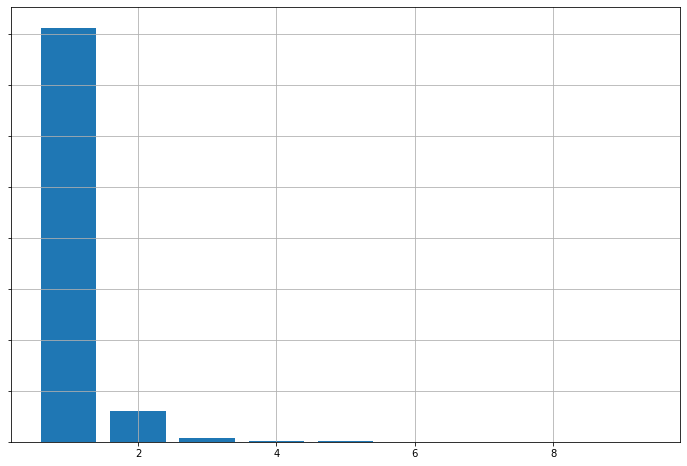

In [31]:
%%local
#刷新次數人次表
plt.figure(figsize=(12,8))
user = user.sort_values('refresh_times')
plt.bar(user['refresh_times'], user['users'])
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
plt.grid(True)

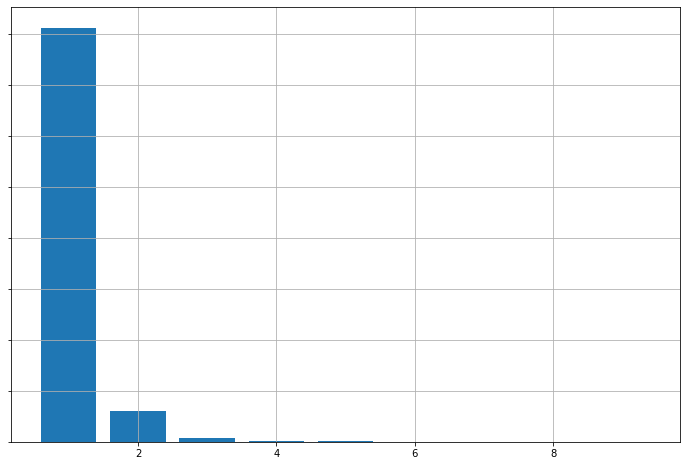

# 位置的impress次數

In [13]:
freq = df_tslog.groupBy('position','row_order').agg(F.sum('was_impressed').alias('impress_times'))
freq.cache()
freq.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+-------------+
|position|row_order|impress_times|
+--------+---------+-------------+
|     307|        1|         1894|
+--------+---------+-------------+
only showing top 1 row

In [14]:
%%spark -o freq -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.0, 500.0)

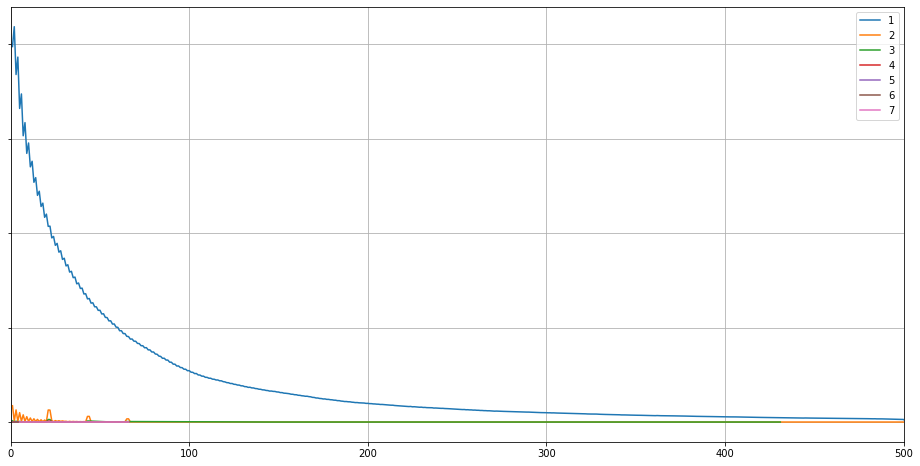

In [92]:
%%local

plt.figure(figsize=(16,8))
for i in range(1,8):
    df = freq[freq['row_order']==i].sort_values('position')
    plt.plot(df['position'], df['impress_times'],label='{}'.format(i))
    
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
plt.grid(True)
plt.legend()
plt.xlim([0,500])

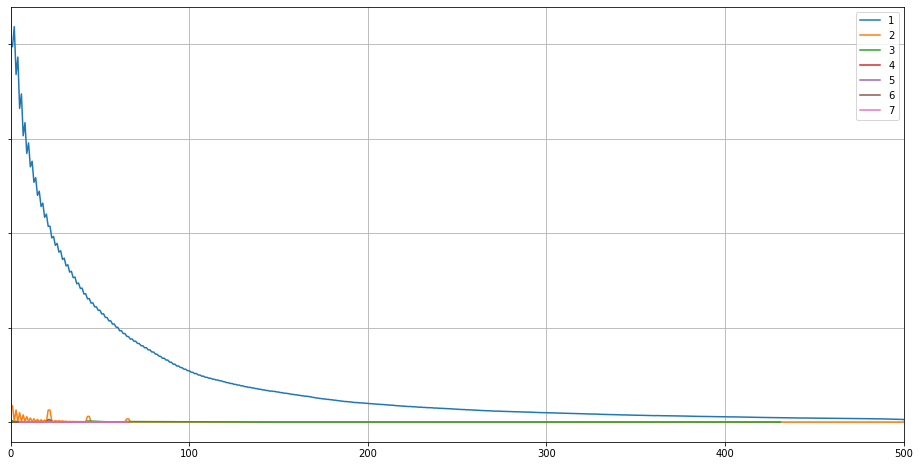

# Top 100

In [93]:
df_tslog = df_tslog.filter((F.col('position')<=100) & (sf.max('row_order')<=3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 重新整理後的點擊率

In [22]:
#refresh more time CTR should be larger
df_refresh = df_tslog.groupBy('requestId','row_order','position').agg(F.sum('was_clicked').alias('click_times'),F.sum('was_impressed').alias('impress_times'))  \
.groupBy('row_order','position').agg(F.sum('click_times').alias('click_times'), F.sum('impress_times').alias('impress_times'))  

df_refresh.cache()
df_refresh.show(1)
#重新整理後的點擊率上升

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------+-----------+-------------+
|row_order|position|click_times|impress_times|
+---------+--------+-----------+-------------+
|        3|      22|          6|          523|
+---------+--------+-----------+-------------+
only showing top 1 row

In [90]:
df_refresh.sort(sf.asc('position')).filter(F.col('row_order')==1).show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------+-----------+-------------+
|row_order|position|click_times|impress_times|
+---------+--------+-----------+-------------+
|        1|       1|       4905|        79495|
|        1|       2|       3178|        83707|
|        1|       3|       3724|        73577|
|        1|       4|       2291|        77271|
|        1|       5|       3002|        66397|
|        1|       6|       1828|        69467|
|        1|       7|       2539|        60616|
|        1|       8|       1513|        63394|
|        1|       9|       2099|        56882|
|        1|      10|       1247|        59084|
|        1|      11|       1465|        54035|
|        1|      12|       1162|        55211|
|        1|      13|       1257|        50759|
|        1|      14|       1049|        51746|
|        1|      15|       1136|        47990|
|        1|      16|        954|        48864|
|        1|      17|       1010|        45636|
|        1|      18|        867|        46346|
|        1|  

In [23]:
%%spark -o df_refresh -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

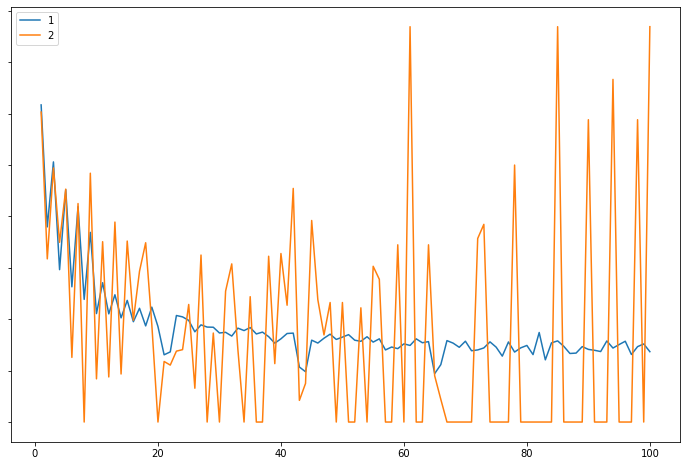

In [94]:
%%local
plt.figure(figsize=(12,8))
for i in range(1,3):
    df = df_refresh[df_refresh['row_order']==i].sort_values('position')
    df['CTR'] = df['click_times']/ df['impress_times']
    plt.plot(df['position'], df['CTR'], label='{}'.format(i))
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
plt.legend()

In [26]:
#重新整理前後看的商品個數差異
df_refresh_2 = df_tslog.groupBy('requestId').agg(sf.max('row_order').alias('refresh_times')).filter(F.col('refresh_times')==2)
df_refresh_2 = df_refresh_2.join(df_tslog,['requestId'],how='left')
df_refresh_2.cache()
df_refresh_2.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+--------------+-----+---------------------------------+-------+--------+-----+--------------+-------------+--------------+-----+-------+----------------+--------+--------------+--------+-------------------+-----------+--------+----------------+---+------------+----------------+-------------+---------+-----------+
|           requestId|refresh_times|           gno|price|                            title|soldNum|     CID|watch|sellerDiscount|rutenDiscount|noShippingCost|pCoin|oversea|shippingDiscount|campaign|limitesDeliver|position|     time_impressed|recommender|sellerId|          gclass| OS|is_mobile_OS|is_mobile_source|was_impressed|row_order|was_clicked|
+--------------------+-------------+--------------+-----+---------------------------------+-------+--------+-----+--------------+-------------+--------------+-----+-------+----------------+--------+--------------+--------+-------------------+-----------+--------+----------------+---+------------+-

In [27]:
df_refresh_2_dien = df_refresh_2.filter(F.col('recommender')=='recmd').groupBy('position','row_order')  \
.agg(F.sum('was_clicked').alias('click_times'), F.sum('was_impressed').alias('impress_times'))
df_refresh_2_other = df_refresh_2.filter(F.col('recommender')!='recmd').groupBy('position','row_order')  \
.agg(F.sum('was_clicked').alias('click_times'), F.sum('was_impressed').alias('impress_times'))
df_refresh_2_dien.cache()
df_refresh_2_dien.show(1)
df_refresh_2_other.cache()
df_refresh_2_other.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+-----------+-------------+
|position|row_order|click_times|impress_times|
+--------+---------+-----------+-------------+
|      92|        2|          0|            7|
+--------+---------+-----------+-------------+
only showing top 1 row

+--------+---------+-----------+-------------+
|position|row_order|click_times|impress_times|
+--------+---------+-----------+-------------+
|      92|        2|          0|            3|
+--------+---------+-----------+-------------+
only showing top 1 row

In [83]:
%%spark -o df_refresh_2_dien -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
%%spark -o df_refresh_2_other -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.0, 50.0)

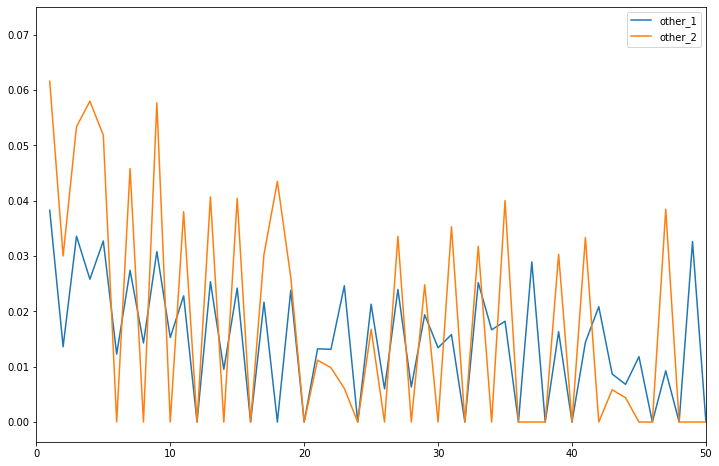

In [99]:
%%local
plt.figure(figsize=(12,8))
df_refresh_2_dien['CTR'] = df_refresh_2_dien['click_times']/df_refresh_2_dien['impress_times']
df_refresh_2_other['CTR'] = df_refresh_2_other['click_times']/df_refresh_2_other['impress_times']
df_refresh_2_dien = df_refresh_2_dien.sort_values('position')
df_refresh_2_other = df_refresh_2_other.sort_values('position')
#plt.plot(df_refresh_2_dien[df_refresh_2_dien['row_order']==1]['position'],df_refresh_2_dien[df_refresh_2_dien['row_order']==1]['CTR'],label='dien_1')
#plt.plot(df_refresh_2_dien[df_refresh_2_dien['row_order']==2]['position'],df_refresh_2_dien[df_refresh_2_dien['row_order']==2]['CTR'],label='dien_2')
#plt.legend()
#plt.figure(figsize=(12,8))
plt.plot(df_refresh_2_other[df_refresh_2_other['row_order']==1]['position'],df_refresh_2_other[df_refresh_2_other['row_order']==1]['CTR'],label='other_1')
plt.plot(df_refresh_2_other[df_refresh_2_other['row_order']==2]['position'],df_refresh_2_other[df_refresh_2_other['row_order']==2]['CTR'],label='other_2')
plt.legend()
plt.xlim([0,50])

In [78]:
%%local
df_refresh_2_dien['position'] = np.ceil(df_refresh_2_dien['position']/2)

27      1.0
49      1.0
12      1.0
106     1.0
145     2.0
       ... 
115    49.0
155    50.0
142    50.0
74     50.0
116    50.0
Name: position, Length: 200, dtype: float64

In [67]:
df_refresh_2_other

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[position: int, row_order: int, click_times: bigint, impress_times: bigint]

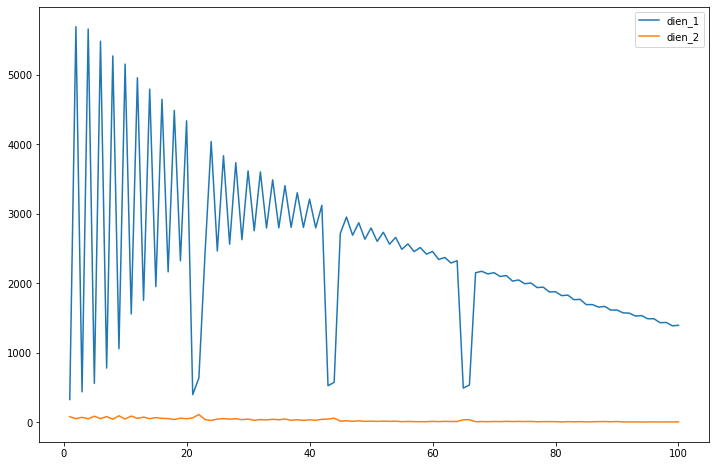

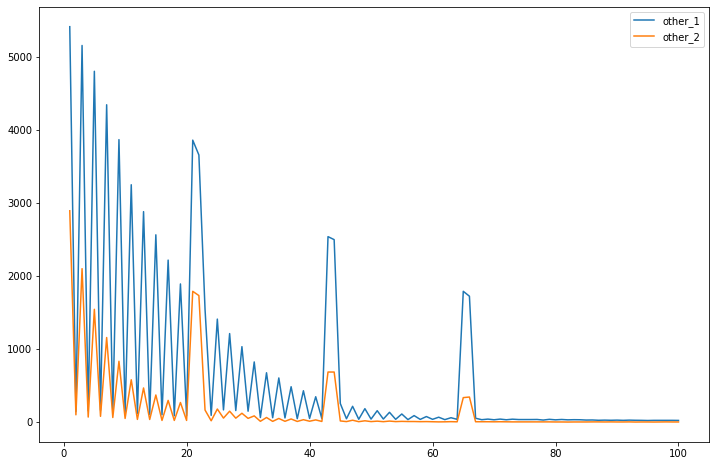

In [86]:
%%local
plt.figure(figsize=(12,8))
df_refresh_2_dien = df_refresh_2_dien.sort_values('position')
df_refresh_2_other = df_refresh_2_other.sort_values('position')
plt.plot(df_refresh_2_dien[df_refresh_2_dien['row_order']==1]['position'],df_refresh_2_dien[df_refresh_2_dien['row_order']==1]['impress_times'],label='dien_1')
plt.plot(df_refresh_2_dien[df_refresh_2_dien['row_order']==2]['position'],df_refresh_2_dien[df_refresh_2_dien['row_order']==2]['impress_times'],label='dien_2')
plt.legend()
plt.figure(figsize=(12,8))
plt.plot(df_refresh_2_other[df_refresh_2_other['row_order']==1]['position'],df_refresh_2_other[df_refresh_2_other['row_order']==1]['impress_times'],label='other_1')
plt.plot(df_refresh_2_other[df_refresh_2_other['row_order']==2]['position'],df_refresh_2_other[df_refresh_2_other['row_order']==2]['impress_times'],label='other_2')
plt.legend()

In [ ]:
df_refresh_2.filter((F.col('row_order')==2)&(F.col('recommender')=='recmd')).count()

In [ ]:
df_tslog.filter((F.col('row_order')==2)&(F.col('recommender')=='recmd')).count()

In [ ]:
df_refresh_3 = df_refresh_2.groupBy('row_order','recommender').agg(F.sum('was_clicked').alias('click_times'), F.count('was_clicked').alias('impress_times'), sf.max('position').alias('max_impress'))  \
.withColumn('CTR',F.col('click_times')/F.col('impress_times'))
df_refresh_3.cache()

In [ ]:
df_refresh_3.sort(sf.asc('row_order')).show()

In [ ]:
%%spark -o df_refresh_3

In [ ]:
%%local
df_refresh_3 = df_refresh_3.sort_values('recommender')
labels = list(df_refresh_3[df_refresh_3['row_order']==1]['recommender'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_refresh_3[df_refresh_3['row_order']==1]['CTR'], width, label='1')
rects2 = ax.bar(x + width/2, df_refresh_3[df_refresh_3['row_order']==2]['CTR'], width, label='2')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('CTR')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
%%local
df_refresh_3 = df_refresh_3.sort_values('recommender')
labels = list(df_refresh_3[df_refresh_3['row_order']==1]['recommender'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_refresh_3[df_refresh_3['row_order']==1]['impress_times'], width, label='1')
rects2 = ax.bar(x + width/2, df_refresh_3[df_refresh_3['row_order']==2]['impress_times'], width, label='2')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('impress_times')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

#fixme: check DIEN row2

In [ ]:
%%local
df_refresh_3 = df_refresh_3.sort_values('recommender')
labels = list(df_refresh_3[df_refresh_3['row_order']==1]['recommender'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_refresh_3[df_refresh_3['row_order']==1]['impress_times']/df_refresh_3[df_refresh_3['row_order']==1]['impress_times'].sum(), width, label='1')
rects2 = ax.bar(x + width/2, df_refresh_3[df_refresh_3['row_order']==2]['impress_times']/df_refresh_3[df_refresh_3['row_order']==2]['impress_times'].sum(), width, label='2')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('impress_ratio(%)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
df_duration = df_tslog.groupBy('requestId').agg(sf.max('row_order').alias('refresh_times'), F.sum('was_clicked').alias('click_times'), F.count('row_order').alias('impress_times'), F.min('duration_with_impress').alias('duration_with_impress'))  \
.filter(F.col('refresh_times')==1)  \
.groupBy('duration_with_impress').agg(F.sum('click_times').alias('click_times'), F.sum('impress_times').alias('impress_times'))  


In [ ]:
df_duration = df_tslog.withColumn("duration_with_impress", F.unix_timestamp(F.col("time_impressed")) - F.unix_timestamp(F.col("timestamp"))) \
.withColumn("duration_with_impress",F.col("duration_with_impress").cast(IntegerType())) \
.filter(F.col('duration_with_impress').isNotNull()) \
.filter(F.col('position').isNotNull())

specWindow = Window().partitionBy("requestID")
df_duration = df_duration.withColumn("gap_req_to_imprs", sf.min("duration_with_impress").over(specWindow))

In [ ]:
df_duration.show(10)

In [ ]:
df_duration = df_duration.select('requestId', 'recommender', 'gap_req_to_imprs', 'duration_with_impress', 'row_order')
df_duration.cache()

In [ ]:
df_duration.select('recommender').distinct().show()

In [ ]:
%%spark -o df_duration -n -1

# Discount

In [32]:
#discount
df_discount = df_tslog.groupBy(['position','sellerDiscount','rutenDiscount','noShippingCost','pCoin','oversea','shippingDiscount','campaign','limitesDeliver'])  \
.agg(F.sum('was_clicked').alias('click_times'),F.sum('was_impressed').alias('impress_times'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
df_discount.cache()
df_discount.show(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------+-------------+--------------+-----+-------+----------------+--------+--------------+-----------+-------------+
|position|sellerDiscount|rutenDiscount|noShippingCost|pCoin|oversea|shippingDiscount|campaign|limitesDeliver|click_times|impress_times|
+--------+--------------+-------------+--------------+-----+-------+----------------+--------+--------------+-----------+-------------+
|      30|         false|        false|          true| true|  false|            true|   false|         false|         40|         1981|
+--------+--------------+-------------+--------------+-----+-------+----------------+--------+--------------+-----------+-------------+
only showing top 1 row

In [37]:
%%spark -o df_discount -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KeyError: ('click_times', 'sum')

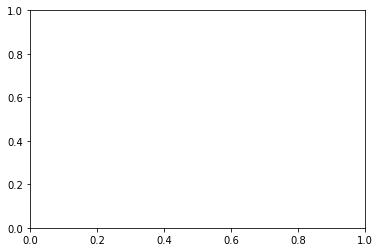

In [38]:
%%local
discount_list = ['sellerDiscount','rutenDiscount','noShippingCost','pCoin','oversea','shippingDiscount','campaign','limitesDeliver']
fig , ax = plt.subplots()
fig.subplots_adjust(hspace=0.4, wspace=0.4) #設定子圖的間隔
for i, discount in enumerate(discount_list):
    df = df_discount.groupby(['position',discount]).agg({"click_times":"sum","impress_times":"sum"})
    df['CTR'] = df[('click_times','sum')] / df[('impress_times','sum')] 
    df = df.sort_values('position')
    plt.subplot(3, 3, i)
    plt.plot(df[df[discount]==0]['position'], df[df[discount]==0]['CTR'], color = 'r', label='0')
    plt.plot(df[df[discount]==1]['position'], df[df[discount]==1]['CTR'], color = 'b', label='1')
    plt.set_ticklabels([])
    plt.legend()

In [51]:
%%local
df.in

'click_times'

In [49]:
%%local
df.columns = ['click_times','impress_times']

KeyError: ('click_times', 'sum')